In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings('ignore')


In [32]:
df = pd.read_csv(r"C:\Users\bollapalli bharadwaj\Downloads\StoreDemand.csv")

display(df.head())
display(df.tail())

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


,date,store,item,sales
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


In [26]:
df.shape

(913000, 4)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [28]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [33]:
parts = df["date"].str.split("-", n=3, expand=True)
df["year"]  = parts[0].astype(int)
df["month"] = parts[1].astype(int)
df["day"]   = parts[2].astype(int)
df.head()

,date,store,item,sales,year,month,day
0,2013-01-01,1,1,13,2013,1,1
1,2013-01-02,1,1,11,2013,1,2
2,2013-01-03,1,1,14,2013,1,3
3,2013-01-04,1,1,13,2013,1,4
4,2013-01-05,1,1,10,2013,1,5


In [34]:
from datetime import datetime

def weekend_or_weekday(year, month, day):
    d = datetime(year, month, day)
    return 1 if d.weekday() > 4 else 0

df["weekend"] = df.apply(lambda x: weekend_or_weekday(x["year"], x["month"], x["day"]), axis=1)


In [35]:
import holidays
india_holidays = holidays.country_holidays("IN")
df["holidays"] = df["date"].apply(lambda x: 1 if india_holidays.get(x) else 0)


In [36]:
import numpy as np
df["m1"] = np.sin(df["month"] * (2 * np.pi / 12))
df["m2"] = np.cos(df["month"] * (2 * np.pi / 12))


In [37]:
def which_day(year, month, day):
    return datetime(year, month, day).weekday()

df["weekday"] = df.apply(lambda x: which_day(x["year"], x["month"], x["day"]), axis=1)


In [38]:
df.drop("date", axis=1, inplace=True)


In [39]:
df["weekend"] = df["weekday"].apply(lambda x: 1 if x >= 5 else 0)


In [40]:
from sklearn.preprocessing import LabelEncoder

for col in ["store", "item"]:
    if col in df.columns and not pd.api.types.is_numeric_dtype(df[col]):
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))


In [41]:
if 'store' in df.columns and 'item' in df.columns:
    print("Unique stores, items:", df['store'].nunique(), df['item'].nunique())
features = ['store', 'year', 'month', 'weekday', 'weekend', 'holidays']
features = [f for f in features if f in df.columns]

Unique stores, items: 10 50


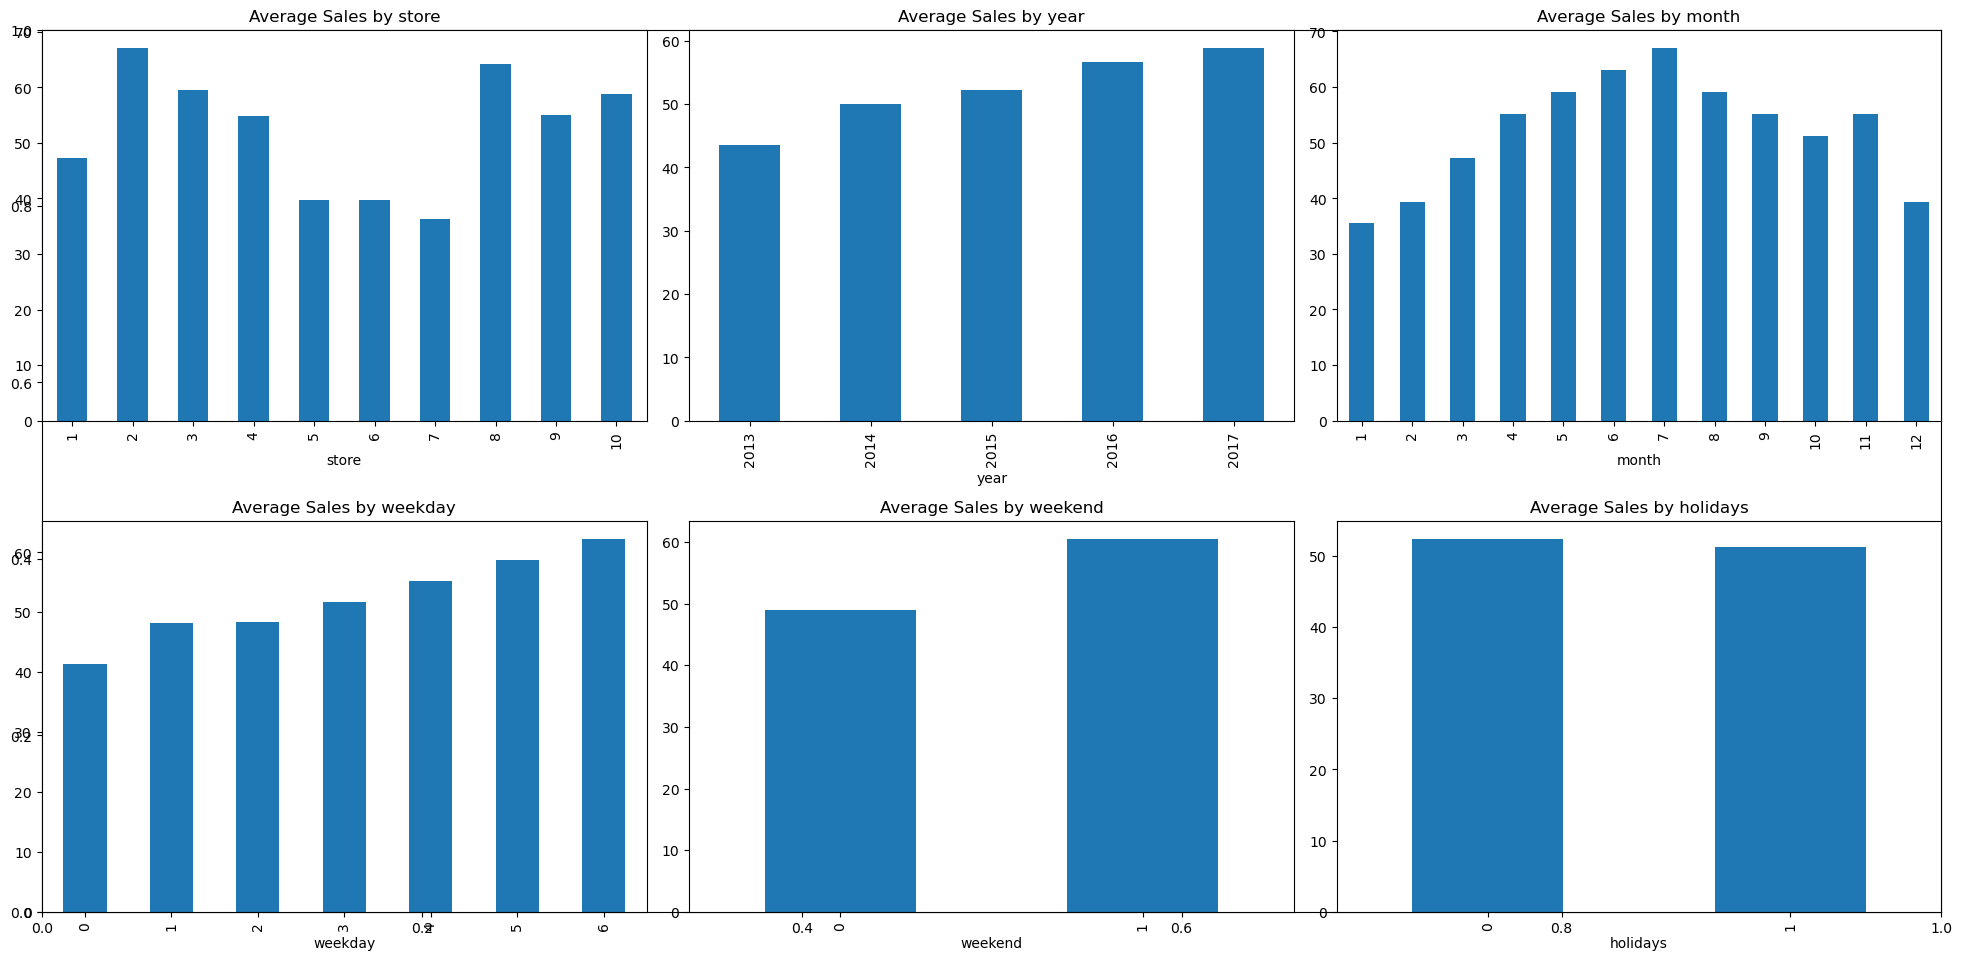

In [42]:
plt.subplots(figsize=(20, 10))
for i, col in enumerate(features):
    plt.subplot(2, 3, i + 1)
    df.groupby(col).mean(numeric_only=True)['sales'].plot.bar()
    plt.title(f'Average Sales by {col}')
plt.tight_layout()
plt.show()

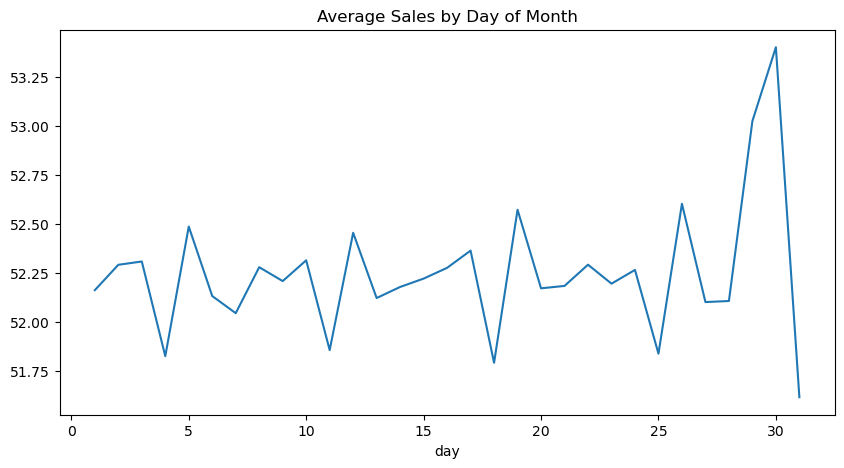

In [43]:
plt.figure(figsize=(10,5))
df.groupby('day').mean(numeric_only=True)['sales'].plot()
plt.title('Average Sales by Day of Month')
plt.show()

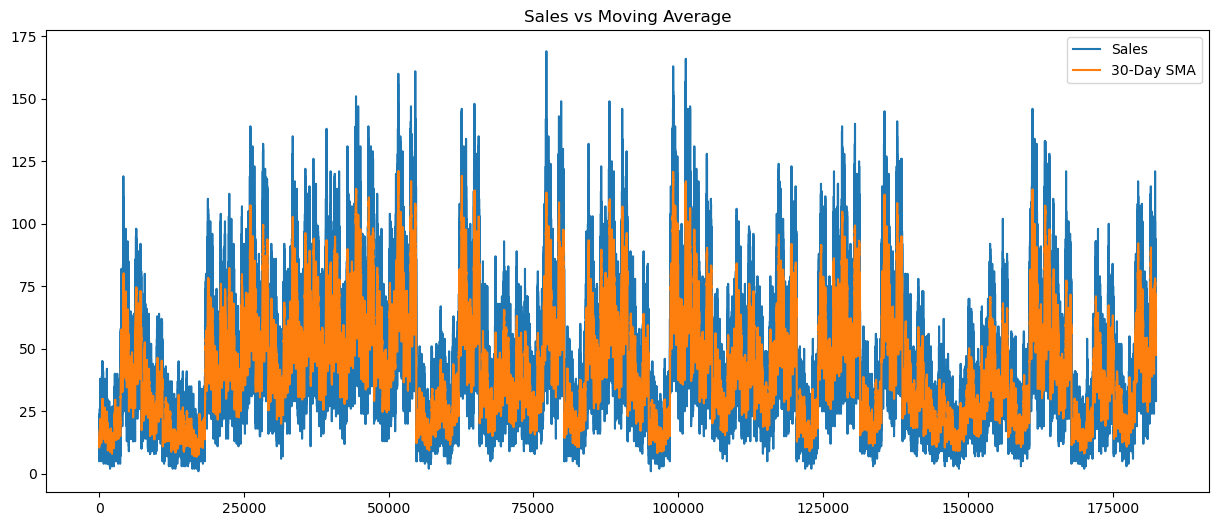

In [44]:
plt.figure(figsize=(15, 6))
if (df['year']==2013).any():
    data = df[df['year']==2013].copy()
else:
    data = df.copy()
window_size = 30
sma = data['sales'].rolling(window_size).mean()
plt.plot(data['sales'].values, label='Sales')
plt.plot(sma.values, label=f'{window_size}-Day SMA')
plt.legend()
plt.title('Sales vs Moving Average')
plt.show()

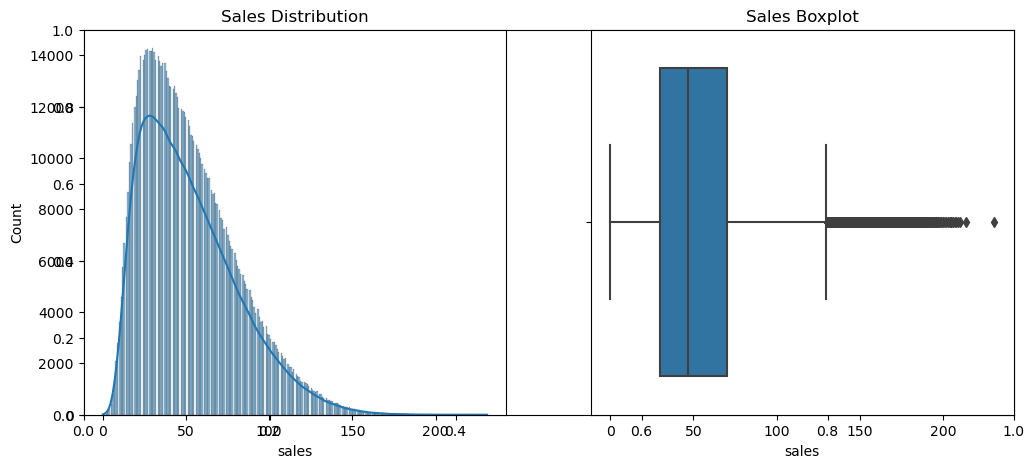

In [45]:
plt.subplots(figsize=(12, 5))
plt.subplot(1, 2, 1)
sb.histplot(df['sales'], kde=True)
plt.title('Sales Distribution')
plt.subplot(1, 2, 2)
sb.boxplot(x=df['sales'])
plt.title('Sales Boxplot')
plt.show()

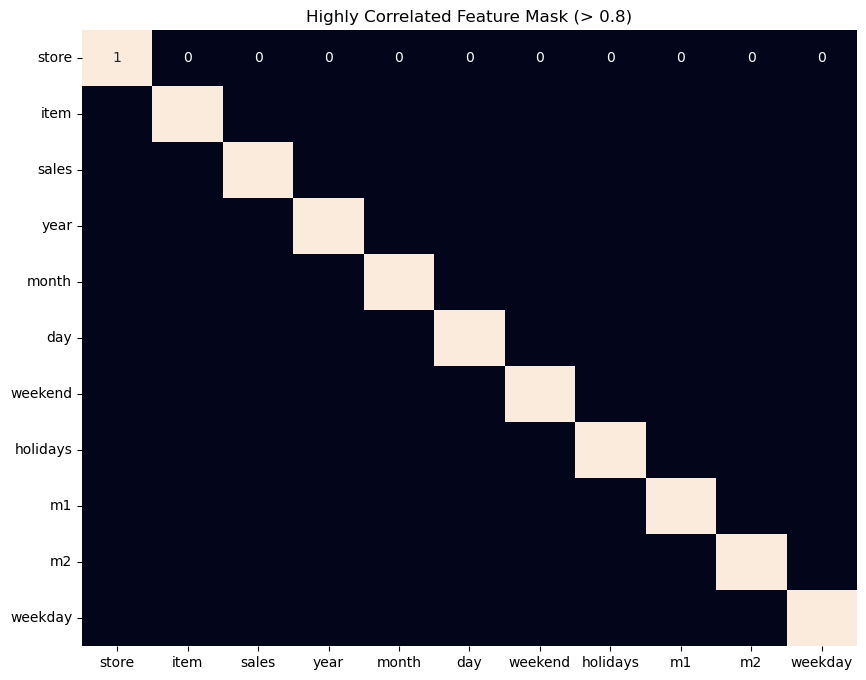

In [46]:
plt.figure(figsize=(10, 8))
corr_mask = df.corr(numeric_only=True) > 0.8
sb.heatmap(corr_mask, annot=True, cbar=False)
plt.title('Highly Correlated Feature Mask (> 0.8)')
plt.show()

In [47]:
df = df[df['sales'] < 140].copy()

In [48]:
features = df.drop(['sales', 'year'], axis=1)
target = df['sales'].values

X_train, X_val, Y_train, Y_val = train_test_split(
    features, target, test_size=0.05, random_state=22
)
print(X_train.shape, X_val.shape)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)

(861170, 9) (45325, 9)


In [49]:
from xgboost import XGBRegressor

models = [
    ("Linear Regression", LinearRegression()),
    ("Decision Tree", DecisionTreeRegressor(max_depth=12, random_state=22)),
    ("XGBoost", XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        tree_method="hist",
        random_state=22
    ))
]

results = []
for name, model in models:
    print("Training:", name)
    model.fit(X_train, Y_train)
    train_preds = model.predict(X_train)
    val_preds   = model.predict(X_val)
    train_mae = mae(Y_train, train_preds)
    val_mae   = mae(Y_val, val_preds)
    results.append((name, train_mae, val_mae))
    print(name)
    print("Training Error:", train_mae)
    print("Validation Error:", val_mae)
    print()


Training: Linear Regression
Linear Regression
Training Error: 20.9030116399358
Validation Error: 20.971878842602617

Training: Decision Tree
Decision Tree
Training Error: 11.58528280024922
Validation Error: 11.692240754395058

Training: XGBoost
XGBoost
Training Error: 7.85437492136562
Validation Error: 7.857432528486814



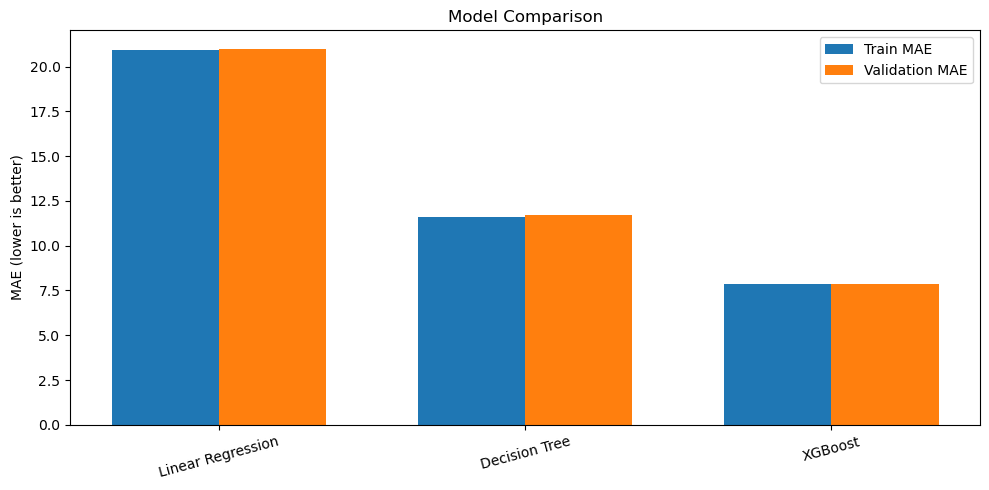

In [50]:
names  = [r[0] for r in results]
mae_tr = [r[1] for r in results]
mae_va = [r[2] for r in results]

x = np.arange(len(names))
w = 0.35

plt.figure(figsize=(10,5))
plt.bar(x - w/2, mae_tr, width=w, label='Train MAE')
plt.bar(x + w/2, mae_va, width=w, label='Validation MAE')
plt.xticks(x, names, rotation=15)
plt.ylabel('MAE (lower is better)')
plt.title('Model Comparison')
plt.legend()
plt.tight_layout()
plt.show()


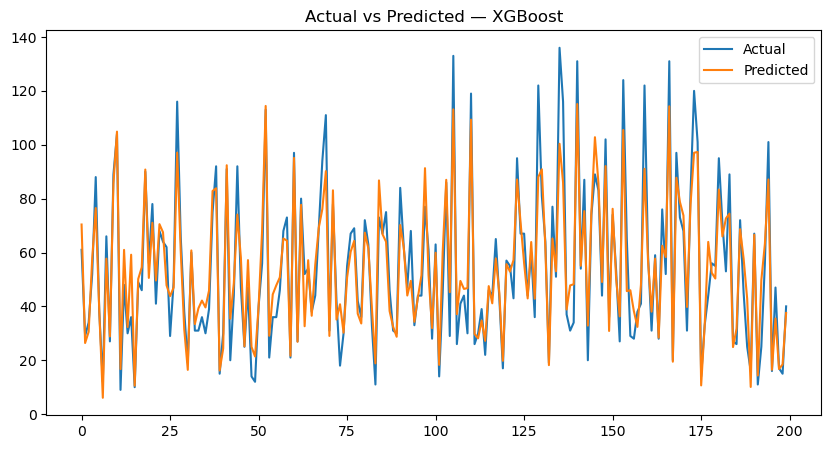

In [52]:
best_name, _, _ = min(results, key=lambda t: t[2])
best_model = dict(models)[best_name]

pred = best_model.predict(X_val)

n = min(200, len(pred))
plt.figure(figsize=(10,5))
plt.plot(Y_val[:n], label='Actual')
plt.plot(pred[:n], label='Predicted')
plt.title(f'Actual vs Predicted — {best_name}')
plt.legend()
plt.show()


In [53]:
predicted = best_model.predict(X_val)

In [54]:
output_df = pd.DataFrame({
    "Actual_Sales": Y_val[:20],
    "Predicted_Sales": predicted[:20]
})
output_df


,Actual_Sales,Predicted_Sales
0,61,70.392090
1,29,26.408747
2,34,30.581022
3,52,57.690643
4,88,76.505486
5,38,38.223850
6,12,6.068489
7,66,57.724293
8,27,28.822409
9,89,85.704140
